The SPDFM software is a script that its main duty is to translate partial differential equations governing a physical phenomenon called surface plasmon for a finite element method PDE solver (FEniCS). 



# Solving Maxwell's equations using FEniCS

Maxwell's time harmonic equations: 

In [24]:
%%latex
\begin{equation}
\nabla \times \vec{\mathbf{H}} = -i \omega \epsilon_0 \epsilon_{loc} \vec{\mathbf{E}} + \vec{\mathbf{J_{HD}}} 
\end{equation}

\begin{equation}
\nabla \times \vec{\mathbf{E}} = -i \omega\mu_0 \vec{\mathbf{H}} 
\end{equation}

\begin{equation}
\nabla \cdot \vec{\mathbf{D}} = - e n 
\end{equation}

\begin{equation}
\nabla \cdot \vec{\mathbf{B}} =  0   
\end{equation}

<IPython.core.display.Latex object>

Time domain: 

In [25]:
from IPython.display import Latex
Latex(r"""\begin{eqnarray}
\nabla \times \vec{\mathbf{B}} -\, \frac1c\, \frac{\partial\vec{\mathbf{E}}}{\partial t} & = \frac{4\pi}{c}\vec{\mathbf{j}} \\
\nabla \cdot \vec{\mathbf{E}} & = 4 \pi \rho \\
\nabla \times \vec{\mathbf{E}}\, +\, \frac1c\, \frac{\partial\vec{\mathbf{B}}}{\partial t} & = \vec{\mathbf{0}} \\
\nabla \cdot \vec{\mathbf{B}} & = 0 
\end{eqnarray}""")

<IPython.core.display.Latex object>

An example of using FEniCS for solving Maxwell's eq:

-Finding magnetic vector potential B in static formulation


%%latex

Static formulation: 

\begin{equation}
-i \omega\epsilon_0\epsilon_{loc}E = 0 
\end{equation}

\begin{equation}
-i \omega \mu_0 H = 0
\end{equation}

Therefore there will be a relationship between B and J:
\begin{equation}
J = \nabla \times H = \nabla \times ( \mu_0^{-1} B)
\end{equation}


In [2]:
from fenics import *
from mshr import *
from math import sin, cos, pi


# Defining a system (space)

In [3]:
a = 1.0   # inner radius of iron cylinder
b = 1.2   # outer radius of iron cylinder
c_1 = 0.8 # radius for inner circle of copper wires
c_2 = 1.4 # radius for outer circle of copper wires
r = 0.1   # radius of copper wires
R = 3   # radius of domain
n = 10    # number of windings

# Define geometry for background
domain = Circle(Point(0, 0), R)

# Define geometry for iron cylinder
cylinder = Circle(Point(0, 0), b) - Circle(Point(0, 0), a)

# Define geometry for wires (N = North (up), S = South (down))
angles_N = [i*2*pi/n for i in range(n)]
angles_S = [(i + 0.5)*2*pi/n for i in range(n)]
wires_N = [Circle(Point(c_1*cos(v), c_1*sin(v)), r) for v in angles_N]
wires_S = [Circle(Point(c_2*cos(v), c_2*sin(v)), r) for v in angles_S]


# Separation of the domains:

In [4]:
# Set subdomain for iron cylinder
domain.set_subdomain(1, cylinder)

# Set subdomains for wires
for (i, wire) in enumerate(wires_N):
    domain.set_subdomain(2 + i, wire)
for (i, wire) in enumerate(wires_S):
    domain.set_subdomain(2 + n + i, wire)


# Mesh the space (geometry & function!) you have defined

In [5]:
# Create mesh
mesh = generate_mesh(domain, 32)

# Define function space
V = FunctionSpace(mesh, 'P', 1)

# Define subdomain markers and integration measure
markers = MeshFunction('size_t', mesh, 2, mesh.domains())
dx = Measure('dx', domain=mesh, subdomain_data=markers)


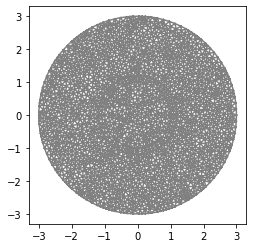

In [6]:
plot(mesh)

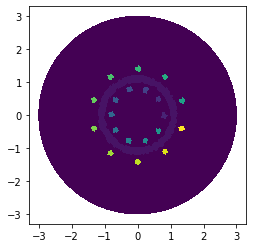

In [7]:
plot(markers)

# Listing known info and boundary conditions

In [8]:
# Define boundary condition
bc = DirichletBC(V, Constant(0), 'on_boundary')


# Define current densities
J_N = Constant(1.0)
J_S = Constant(-1.0)


# Define magnetic permeability
class Permeability(UserExpression): # UserExpression instead of Expression
    def __init__(self, markers, **kwargs):
        super().__init__(**kwargs) # This part is new!
        self.markers = markers
    def eval_cell(self, values, x, cell):
        if self.markers[cell.index] == 0:
            values[0] = 4*pi*1e-7 # vacuum
        elif self.markers[cell.index] == 1:
            values[0] = 1e-5      # iron (should really be 6.3e-3)
        else:
            values[0] = 1.26e-6   # copper

mu = Permeability(markers, degree=1)


# Define the equation and solve it

In [27]:
%%latex
Equations need to be written in their weak form: 
    
    
\begin{equation*}
J = \nabla \times H = \nabla \times ( \mu_0^{-1} B)
\end{equation*}


we assume:
\begin{equation}
B= \nabla \times A_z
\end{equation}

\begin{equation}
J = \nabla \times (\mu_0^{-1} \nabla \times A_z)= - \nabla . (\mu_0^{-1}\nabla A_z)
\end{equation}

\begin{equation}
\lim_{x,y \ -> \inf} A_z = 0
\end{equation}


Weak (variational) form: 

\begin{equation}
\int_\Omega \mu_0^{-1}\  \nabla\  A_z . v \  dx = \int_\Omega J.v \ dx
\end{equation}



<IPython.core.display.Latex object>

In [10]:
# Define variational problem
A_z = TrialFunction(V)
v = TestFunction(V)
a = (1 / mu)*dot(grad(A_z), grad(v))*dx
L_N = sum(J_N*v*dx(i) for i in range(2, 2 + n))
L_S = sum(J_S*v*dx(i) for i in range(2 + n, 2 + 2*n))
L = L_N + L_S

# Solve variational problem
A_z = Function(V)
solve(a == L, A_z, bc)

# Compute magnetic field (B = curl A)
W = VectorFunctionSpace(mesh, 'P', 1)
B = project(as_vector((A_z.dx(1), -A_z.dx(0))), W)

In [11]:
# Save solution to file
vtkfile_A_z = File('magnetostatics/potential.pvd')
vtkfile_B = File('magnetostatics/field.pvd')
vtkfile_A_z << A_z
vtkfile_B << B

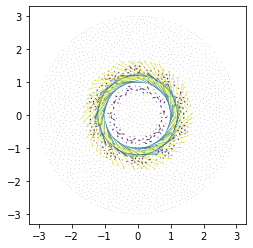

In [12]:
# Plot solution
plot(B)


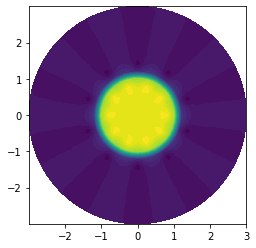

In [13]:
plot (A_z)

# How SPDFM is different?

Goal: Calculate plasmon enhance electric field density and electric current density 

The method selecetd for simulating the target plasmonic system is Finite Elemenet method => FEniCS toolbox

Static -> Hydrodynamic 

External stimuli (light source) -> Internal response 

In [28]:
%%latex

\begin{equation}
\beta^2 \nabla ( \nabla . \vec{\mathbf{J_{HD}}}) \ + \ \omega(\omega+i\gamma)\vec{\mathbf{J_{HD}}}\  = \ i\omega \omega^2_p \epsilon_0 \vec{\mathbf{E}}
\end{equation}

\begin{equation}
\nabla \times \mu^{-1}_0 (\nabla \times \vec{\mathbf{E}})\ - \ \omega^2 \epsilon_0 (1-\frac{\omega^2_p}{\omega^2+i\omega\gamma}) \vec{\mathbf{E}} \ = \ i \omega \vec{\mathbf{J_{HD}}} 
\end{equation}


<IPython.core.display.Latex object>

In [17]:
if __name__ == '__main__':
    
    Input info
    Instruction_print();
    Geometry_input();
    LightSource_input();
    MatProp_input();
    
    Solve the PDE:
    SPD_sover();
    

In [ ]:
def  Instruction_print():
    print("""To initiate SPDFM software simulations user need to provide the software with following information:""","""p = (p1, p2, p3) : 3D light source polarity vector, \{p1, p2, p3\} in R;","d = (d1, d2, d3) : 3D light source propagation direction unit vector, \{d1, d2, d3\} in R;\\
p and d must be perpendicular;\n""", "\n",
"""Wavelength = wl : light source spatial wavelength (nm), wl in R;""",
"""Frequency = freq : light source angular frequency (THz), freq in R;""",
"""Time step = delt\_t : time step (fs), delta\_t in R;""",
"""Final time = t\_final : (fs), t\_final in R;""",
"""provide materials properties in a .csv as instructed;""",
"""Mesh file : address of the .gmsh file.""")
    
    return();

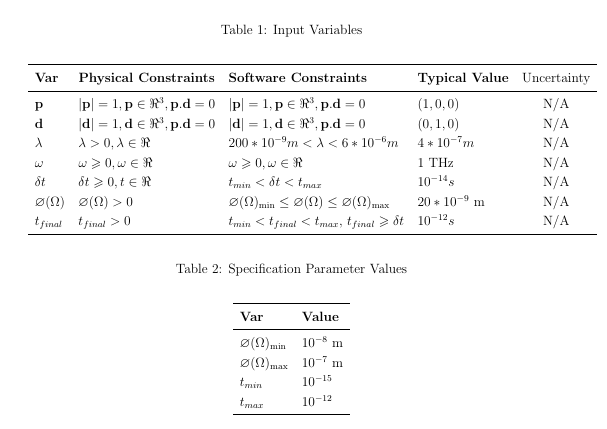

In [18]:
from IPython.display import Image 
img = Image(filename='image.png')
display(img)

In [ ]:
def  Geometry_input():
    global domain
    global marker
    global dx
    #mesh = pymesh.load_mesh("cube.obj");
    domain = Circle(Point(0, 0), 20)
    domain.set_subdomain(1, cylinder)
    
    markers = MeshFunction('size_t', mesh, 2, mesh.domains())
    dx = Measure('dx', domain=mesh, subdomain_data=markers)

    

In [ ]:
def LightSource ():
    global p
    global d
    global wl
    global dt
    
#   p=array(input("input p:"))
#    print(p)
#    d=array(input("input d:"))
#    print(d)
#    wl=input("input the wavelength:")
#    dt=input("input the time step:")
    
    p=(1,0,0)
    d=(0,1,0)
    
    wl=530
    
    dt=0
    
    return();

In [19]:
%%latex 
In presence of the light source:

    
\begin{equation} \begin{gathered} 
    \textbf{E}_{i}= \textbf{p}\ [ cos(k\textbf{d.r}-\omega t)- i \ sin(k\textbf{d.r}-\omega t)] 
    \end{gathered} \end{equation}

    
Free electrons can couple with photons and oscillate collectively: 
    
    

<IPython.core.display.Latex object>

In [ ]:
def MatProp():
    
    #matprop=csv.read();
    
    
    

Function space here is different from the previouse example: 

In [20]:
%%latex

\begin{equation}
\nabla ( \nabla . \vec{\mathbf{J_{HD}}}) \ + \ (1+i)\vec{\mathbf{J_{HD}}}\  = \ i \vec{\mathbf{E}}
\end{equation}

\begin{equation}
\nabla \times (\nabla \times \vec{\mathbf{E}})\ - \ (1-i) \vec{\mathbf{E}} \ = \ i  \vec{\mathbf{J_{HD}}} 
\end{equation}


<IPython.core.display.Latex object>


Instead of 1 function space we have 2 => J and E
Instead of a real component we have complex components: 


In [21]:
%%latex

\begin{equation}
\nabla ( \nabla . (\vec{\mathbf{J_{HD}^r}} + i\ \vec{\mathbf{J_{HD}^i}})) \ + \ (1+i)(\vec{\mathbf{J_{HD}^r}} + i\ \vec{\mathbf{J_{HD}^i}})\  = \ i (\vec{\mathbf{E^r}} + i\ \vec{\mathbf{E^i}})
\end{equation}

\begin{equation}
\nabla \times (\nabla \times  (\vec{\mathbf{E^r}} + i\ \vec{\mathbf{E^i}}))\ - \ (1-i)  (\vec{\mathbf{E^r}} + i\ \vec{\mathbf{E^i}}) \ = \ i  (\vec{\mathbf{J_{HD}^r}} + i\ \vec{\mathbf{J_{HD}^i}})
\end{equation}


<IPython.core.display.Latex object>

In [22]:
%%latex
REAL Equations: 
    
\begin{equation}
\nabla ( \nabla . \vec{\mathbf{J_{HD}^r}}) \ + \ \vec{\mathbf{J_{HD}^r}} - \vec{\mathbf{J_{HD}^i}}\  = - \vec{\mathbf{E^i}}
\end{equation}

\begin{equation}
\nabla \times (\nabla \times \vec{\mathbf{E^r}})\ - \ \vec{\mathbf{E^r}} + \vec{\mathbf{E^i}} \ = -\vec{\mathbf{J_{HD}^i}}
\end{equation}


IMAGINARY Equations: 

\begin{equation}
\nabla ( \nabla . (i\ \vec{\mathbf{J_{HD}^i}})) \ + \ i\ (\vec{\mathbf{J_{HD}^r}} + \vec{\mathbf{J_{HD}^i}})\  = \ i \ \vec{\mathbf{E^r}} 
\end{equation}

\begin{equation}
\nabla \times (\nabla \times  ( i\ \vec{\mathbf{E^i}}))\ - \ i\  (\vec{\mathbf{E^i}} - \vec{\mathbf{E^r}}) \ = \ i  \vec{\mathbf{J_{HD}^r}}
\end{equation}


<IPython.core.display.Latex object>



Although in theory system of equation is defined as below for usinf FEM this system should be refined for implementation!



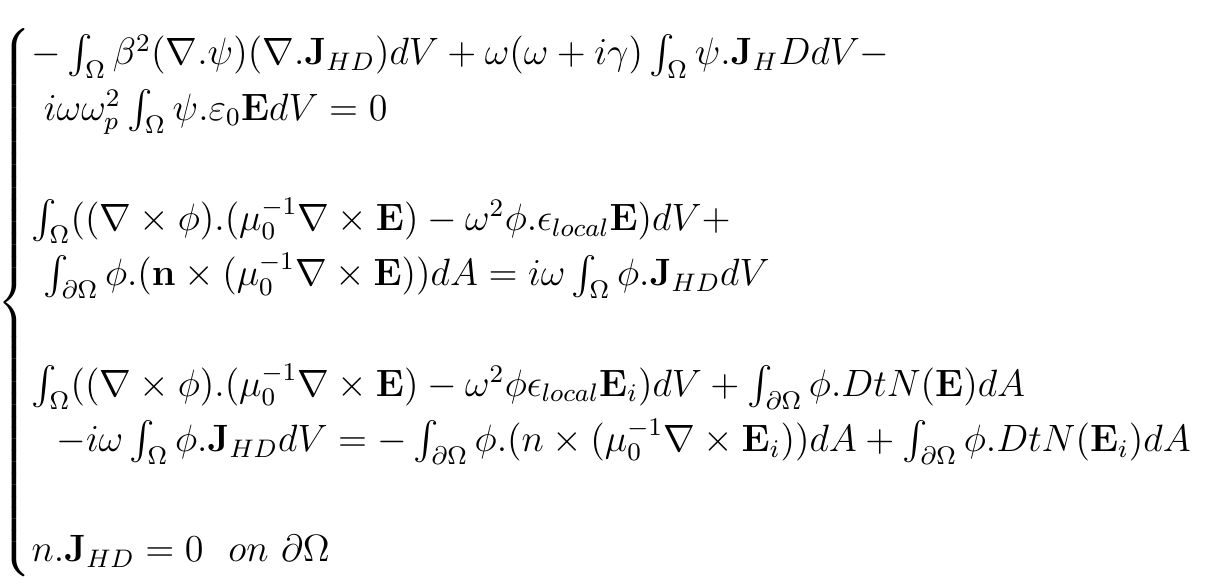

In [23]:
from IPython.display import Image 
img2 = Image(filename='im2.png')
display(img2)



When variational forms are written -> implementation  


In [ ]:
def SPD_solver():
    
    P1 = VectorElement('P', triangle, 1) #instead of finite element
    element = MixedElement([P1, P1, P1, P1])
    V = FunctionSpace(mesh, element)
    
    #Test function:
    v_1, v_2, v_3, v_4  = TestFunctions(V)
    
    #Trial function -> not really trial because we are in nonlinear condition
    u = Function(V)
    u_1, u_2, u_3, u_4 = split(u)
    
    F = "?"
    BC= "?"

    t = 0
    for n in range(num_steps):
        t += dt
        timeseries_w.retrieve(w.vector(), t)
        solve(F == 0, u)
        
        
        u_1, u_2, u_3, u_4 = u.split()
        vtkfile_u_1 << (_u_1, t)
        vtkfile_u_2 << (_u_2, t)
        vtkfile_u_3 << (_u_3, t)

        # Update previous solution
        u_n.assign(u)

        # Update progress bar
        progress.update(t / T)
        
        
        u_n.assign(u)
    

In [ ]:
class Permitivity(UserExpression): # UserExpression instead of Expression
    def __init__(self, markers, **kwargs):
        super().__init__(**kwargs) # This part is new!
        self.markers = markers
    def eval_cell(self, values, x, cell):
        if self.markers[cell.index] == 0:
            values[0] = 4*pi*1e-7 # vacuum
        else :
            values[0] = 1e-5      # iron (should really be 6.3e-3)
            
eps = Permitivity(markers, degree=1)

In [ ]:
%%latex
Define a geometery:

In [ ]:
domain = Circle(Point(0, 0), 20)

In [ ]:
%%latex
Set subdomain for geometry:

In [ ]:
domain.set_subdomain(1, cylinder)

In [ ]:
# Create mesh
mesh = generate_mesh(domain, 16)

In [ ]:
plot(mesh)

In [ ]:
from IPython.display import Latex
Latex(r"""\begin{eqnarray}
\nabla \times \vec{\mathbf{H}} & = -i \omega \epsilon_0 \epsilon_{loc} \vec{\mathbf{E}} + \vec{\mathbf{J_{HD}}} \\
\nabla \times \vec{\mathbf{E}} & = -i \omega\mu_0 \vec{\mathbf{H}}  \\
\nabla \cdot \vec{\mathbf{D}} & = - e n  \\
\nabla \cdot \vec{\mathbf{B}} & =  0   
\end{eqnarray}""")



In [ ]:
%%latex
\begin{equation}\label{eq:}
\nabla \times \vec{\mathbf{E}} = -i \omega\mu_0 \vec{\mathbf{H}} 
\end{equation}

In [ ]:
%%latex
\begin{equation}
\nabla \times \vec{\mathbf{H}} = -i \omega \epsilon_0 \epsilon_{loc} \vec{\mathbf{E}} + \vec{\mathbf{J_{HD}}}
\end{equation}

In [ ]:
%%latex
\begin{equation}
\nabla \times \vec{\mathbf{H}} = -i \omega \epsilon_0 \epsilon_{loc} \vec{\mathbf{E}} + \vec{\mathbf{J_{HD}}}
\end{equation}

In [ ]:
from IPython.display import Latex
Latex(r"""\begin{eqnarray}
\nabla \times \vec{\mathbf{B}} -\, \frac1c\, \frac{\partial\vec{\mathbf{E}}}{\partial t} & = \frac{4\pi}{c}\vec{\mathbf{j}} \\
\nabla \cdot \vec{\mathbf{E}} & = 4 \pi \rho \\
\nabla \times \vec{\mathbf{E}}\, +\, \frac1c\, \frac{\partial\vec{\mathbf{B}}}{\partial t} & = \vec{\mathbf{0}} \\
\nabla \cdot \vec{\mathbf{B}} & = 0 
\end{eqnarray}""")

In [ ]:
# Create mesh
mesh = generate_mesh(domain, 128)